In this notebook we shall focus on overfitting, demonstrating the phenomenon and studying techniques to address it. 
The dataset we shall use is the IMDB movie reviews dataset, composed of 25,000 movies reviews, labeled by sentiment (positive/negative).

To prevent overfitting, the best solution is to use more training data. When that is not a,viable possibility, 
you can try to use regularization techniques, constraining the quantity and quality of information stored by the model. 
If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on 
the most prominent ones, which have a better chance of generalizing well.

In [24]:
from keras.layers import Input,Dense
from keras.models import Model
from keras.datasets import imdb
import matplotlib.pyplot as plt
import numpy as np

 Let us load the dataset. In keras, the dataset is preprocessed, and each review is encoded as a sequence of word indexes (integers). 
 For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer \"3\" encodes the 3rd most frequent word in the data.

In [25]:
num_words=500
(x_train,y_train),(x_test,y_test)=imdb.load_data(path="imdb.npz",num_words=num_words)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Let's look at the encoding of the first review

In [26]:
print(len(x_train[0]))
print(len(x_train[1]))

218
189


This representation has a variable length dimension, that is not very stuitable for a neural network.
Let us transform it into a multi_hot encoding of of dimension equal to num_words. In this representation, a word gets index 1 if it appears in the document. It is essentially a bag-of-words encoding.

In [27]:
def multi_hot_sequences(sequences, dimension):
  multi_hot = np.zeros((len(sequences),dimension))
  for i in range(0,len(sequences)):
    multi_hot[i, sequences[i]] = 1
    return multi_hot
x_train = multi_hot_sequences(x_train, num_words)
x_test = multi_hot_sequences(x_test, num_words)

Let us have a look at the initial part of the encoding for the first review.

In [28]:
print(x_train[0,0:30])

[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 0.]


We now define our first model, that is just a concatenation of three dense layers.

In [29]:
seq=Input(shape=(num_words,))
x=Dense(64,activation='relu')(seq)
x=Dense(16,activation='relu')(x)
x=Dense(1,activation='sigmoid')(x)

base_model=Model(seq,x)
base_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32064     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 33,121
Trainable params: 33,121
Non-trainable params: 0
_________________________________________________________________


We compile the model using adam as optimizer, and binary crossentropy (log likelyhood) as loss function. The fit function returns a history of the training, that can be later inspected. In addition to the loss function, that is the canonical metric used for training, we also ask the model to keep trace of accuracy.

In [30]:
base_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [31]:
base_history=base_model.fit(x_train,y_train,epochs=6,batch_size=512,validation_data=(x_test,y_test),verbose=1)

Epoch 1/6
49/49 [==============================] - 1s 11ms/step - loss: 0.6932 - accuracy: 0.4920 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/6
49/49 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.5054 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/6
49/49 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/6
49/49 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/6
49/49 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/6
49/49 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.5000


Let us see the keys available in our history

In [32]:
print(base_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


The following function allows us to plot the results
Here we are overfitting with the training set because the same improvement in not reflected on the test set Because the  loss function of the test set is the same

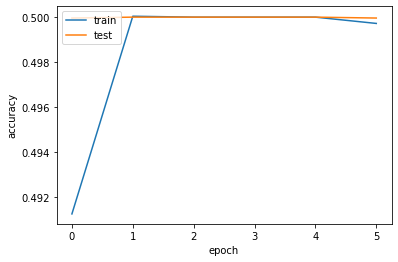

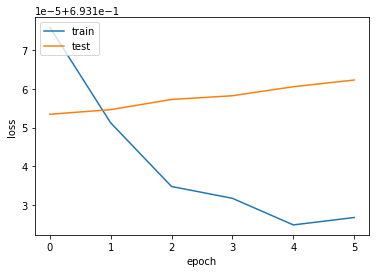

In [33]:
def plot_history(model_history,keys):
  m,val_m = keys
  plt.plot(model_history.history[m]),
  plt.plot(model_history.history[val_m]),
  plt.ylabel(m),
  plt.xlabel('epoch'),
  plt.legend(['train', 'test'], loc='upper left'),
  plt.show(),
plot_history(base_history,['accuracy','val_accuracy']),
plot_history(base_history,['loss','val_loss'])

Weight Regularization

Now we modify our base model adding regularizers.
A common way to mitigate overfitting is to reduce the complexity of the network by forcing its weights to only take small values, 
making the distribution of weights more “regular”. This is called “weight regularization”, and it is done by adding to the loss function of 
the network an additional cost associated with having large weights.

Regularization technicques occur on the weights not on the biases 
You can have other types of regularization also such as activation of the layer
Here we are using L2 regularization

In [34]:
from keras import regularizers
seq = Input(shape=(num_words,))
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005))(seq)
x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.005))(x)
x = Dense(1, activation='sigmoid')(x)
l2reg_model = Model(seq, x)

In [35]:
l2reg_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [36]:
l2reg_history=l2reg_model.fit(x_train,y_test,epochs=5,batch_size=512,validation_data=(x_test,y_test),verbose=2)

Epoch 1/5
49/49 - 1s - loss: 1.0772 - accuracy: 0.4977 - val_loss: 0.8673 - val_accuracy: 0.5000
Epoch 2/5
49/49 - 0s - loss: 0.7917 - accuracy: 0.5000 - val_loss: 0.7435 - val_accuracy: 0.5000
Epoch 3/5
49/49 - 0s - loss: 0.7260 - accuracy: 0.4953 - val_loss: 0.7139 - val_accuracy: 0.5000
Epoch 4/5
49/49 - 0s - loss: 0.7080 - accuracy: 0.5000 - val_loss: 0.7032 - val_accuracy: 0.5000
Epoch 5/5
49/49 - 0s - loss: 0.7004 - accuracy: 0.4972 - val_loss: 0.6980 - val_accuracy: 0.5000


Here we see the loss function decreases slightly for both the traing and testing set

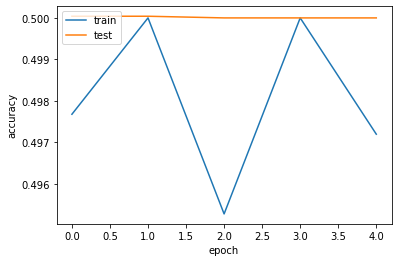

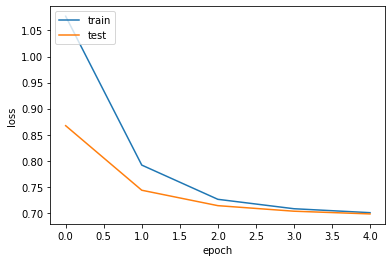

In [38]:
plot_history(l2reg_history,['accuracy','val_accuracy'])
plot_history(l2reg_history,['loss','val_loss'])

DropOut

Dropout is an alternativeregularization techniques for neural networks. It consists of randomly “dropping out” (i.e. set to zero) a number of output features of the layer during training.
At test time, no units are dropped out, but the layer’s output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In [42]:
from keras.layers import Dropout
from keras import optimizers

Let’s add a couple of dropout layers in our IMDB network and see how it performs.

In [44]:
seq = Input(shape=(num_words,))
x = Dense(64, activation='relu')(seq)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
dropout_model = Model(seq, x)

In [45]:
dropout_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [47]:
dropout_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                32064     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 33,121
Trainable params: 33,121
Non-trainable params: 0
_______________________________________________________

In [48]:
dropout_history=dropout_model.fit(x_train,y_train,epochs=5,batch_size=512,validation_data=(x_test,y_test),verbose=1 )

Epoch 1/5
49/49 [==============================] - 1s 11ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
49/49 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
49/49 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.5028 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
49/49 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.4959 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
49/49 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.5000


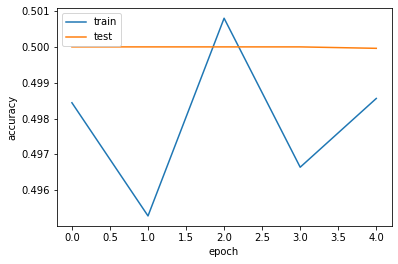

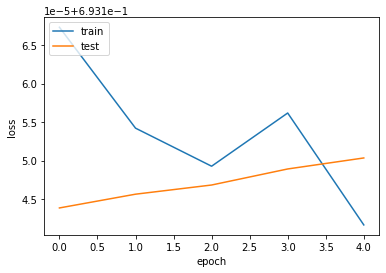

In [52]:
plot_history(dropout_history,['accuracy','val_accuracy'])
plot_history(dropout_history,['loss','val_loss'])

In [54]:
seq = Input(shape=(num_words,))
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005))(seq)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.005))(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
mixed_model = Model(seq, x)

In [55]:
adam=optimizers.Adam(lr=0.001)
mixed_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [56]:
mixed_history=mixed_model.fit(x_train,y_train,epochs=5,batch_size=512,validation_data=(x_test,y_test),verbose=1 )

Epoch 1/5
49/49 [==============================] - 1s 12ms/step - loss: 1.2134 - accuracy: 0.4991 - val_loss: 0.8710 - val_accuracy: 0.5000
Epoch 2/5
49/49 [==============================] - 0s 8ms/step - loss: 0.8263 - accuracy: 0.5013 - val_loss: 0.7454 - val_accuracy: 0.5000
Epoch 3/5
49/49 [==============================] - 0s 9ms/step - loss: 0.7351 - accuracy: 0.5001 - val_loss: 0.7148 - val_accuracy: 0.5000
Epoch 4/5
49/49 [==============================] - 0s 8ms/step - loss: 0.7114 - accuracy: 0.5006 - val_loss: 0.7036 - val_accuracy: 0.5000
Epoch 5/5
49/49 [==============================] - 0s 8ms/step - loss: 0.7020 - accuracy: 0.5018 - val_loss: 0.6982 - val_accuracy: 0.5000


Early Stopping

Early stopping is a method that allows you to stop training as soon as the model performance stops improving on the validation dataset.
This requires that a validation set must be provided to the fit() function.Early stopping can be simply implemented in keras using callbacks.A callback is a function taht is called at specific stages of the training procedure: start/end of epochs, start end of minibatches, etc.You can use callbacks to get a view on internal states and statistics of the model during training. A list of callbacks can be passed to the .fit() function using the keyword argument \"callbacks\

Early stopping is a technicque in which our loss function is not iimproving anymore
There are generally two ways of doing this
1. keras
2. do not use fit function anymore u can use the random batch 
or ALternatively use callbacks ,callbacks are the functions automatically used by the system during training



ModelCheckpoint - It is a checkpoint which is saving the checkpoint of the model basically the weights 
i.e the states of the optmizers,learning rate 

We can replace the old checkpoint if the previous one is better 
checkpoint takes lot of memory

In [58]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

saveDir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(saveDir):
  os.makedirs(saveDir)

mixed_model.load_weights(saveDir + 'Cifar10_to256.hdf5')
es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = saveDir + 'Cifar10_to256.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

OSError: ignored

In [59]:
mixed_model.fit(x_train, y_train,
batch_size=512, #batch_size,\n",
epochs= 20,verbose=1,validation_data=(x_test,y_test),callbacks=[es_cb, cp_cb],shuffle=True)

NameError: ignored

In [60]:
loss,acc = mixed_model.evaluate(x_test,y_test)
print(\"test loss = \", loss)
print(\"test accuracy = \", acc)

SyntaxError: ignored

We can see here after 5th epoch our loss function still didn't improve 
But at some point again it started to improve and we save the checkpoint there after thatit didn't improve with three consecutive numbers so we stop at the eight epoch